# Imports

In [1]:
import numpy as np
import pandas as pd
import pickle
from IPython.display import display, clear_output
import re
from tqdm import tqdm
import tensorflow as tf

# tf.enable_eager_execution()
# tf.executing_eagerly()

import string
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#import matplotlib.pyplot as plt
#import seaborn as sns
#!pip install scikit-optimize
# import skopt
# from skopt import BayesSearchCV
# from skopt import gp_minimize, forest_minimize
# from skopt.space import Real, Categorical, Integer
# from skopt.plots import plot_convergence
# from skopt.plots import plot_objective, plot_evaluations
# from skopt.plots import plot_histogram, plot_objective_2D
# from skopt.utils import use_named_args

In [2]:
global encode_dict 
encode_dict = {l:i for i,l in enumerate(string.ascii_uppercase + " ", 1)}

In [26]:
#Maximum sequence length including padding
global MAXLEN
MAXLEN = 65

# Functions

In [4]:
# TEST_TXT = "Eirmod horrida ingénii pariant secundum? Cognitionem compositis conséquat dicantur exercitus, intellegitur invenire negat oportet sapientium suam. Ceteris diu erat fecerit, impéndéré intelleges máerores malorum mei re reprehendunt? Constringendos intus mentitum quale urna! Convenire cotidie dixit malé vigiliae?"

In [27]:
def preprocessInput(filename: str) -> pd.DataFrame:
    ''' Preprocess CSV file into a Pandas DataFrame.
    
    Expects the file name or path of a csv file with named columns containing strings representing product names.
    Returns a Pandas Dataframe containing uppercased versions of the strings on each cell.
    
    Parameters
    ----------
    filename : str
        
    Returns
    -------
    df : Pandas DataFrame
    '''  
    df = pd.read_csv(filename)
    print(df.info())
    
    print("Processing file: ---------------------------------------")
    original_count = len(df.index)
    print("Dropping sequences longer than the maxlen:")
    df.drop(df[df[df.columns[0]].apply(len).gt(MAXLEN)].index, inplace = True)
    df.drop(df[df[df.columns[1]].apply(len).gt(MAXLEN)].index, inplace = True)
    new_count = len(df.index)
    print("\tDropped", original_count - new_count, "that exceeded the maximum sequence length.")
    # Uppercase all values
    print("\tUppercasing string sequences.")
    df = df.applymap(lambda x: str.upper(x))
    print("Done processing: --------------------------------------")
    print(df.info())
    return df

In [6]:
def add_noise(w: str, percent: float = 0.1) -> str:
    ''' Adds a specified proportion of noise to a string.
    
    Expects a string and a number stating the percent of noise to add to this string.
    The string is modified by editing, deleting, or adding characters in/to the string.
    The modification to perform is determined randomly by generating a random number from an uniform distribution [0,1].
    If the number is < 1/3 edit one position with new random character.
    If the number is < 2/3 delete one position.
    Finally, if the number is > 2/3 add one random character. 
    
    Parameters
    ----------
    w : str
        The string to add noise to.
    
    percent: float, defaults to 10% if not specified
        Percentange representing the proportion of noise to add to the string.
        
        
    Returns
    -------
    w : str
        Modified string with noise added.
    '''  
    positions = random.choices(range(len(w)), k=int(percent*len(w)))
    print("Adding noise to", int(percent*len(w)), "% of the string")
    for p in positions:
        r = random.uniform(0,1)
        
        # if <1/3 edit one position with new random character, # else if <2/3 delete one position, else add one random character 
        if r <= 0.3333: # edit
            w = w[:p] + random.choice(string.ascii_uppercase) + w[p+1:]
        elif r<= 0.6667: # delete
            w = w[:p] + w[p+1:]
        else: # add
            w = w[:p] + random.choice(string.ascii_uppercase) + w[p:]
    return w

In [7]:
# add_noise(TEST_TXT)

In [8]:
# add_noise(TEST_TXT, .01)

In [9]:
def clean(text: str) -> str:
    '''Removes all the non-ascii and special characters from a string and returns the string's alphabetichal characters with spaces.
    
    Expects a string to be cleaned and removes all the non-ascii and special characters. 
    This is done by applying a substitution to regex matches
    Returns the cleaned string containing uppercased versions of the characters.
    
    Parameters
    ----------
    text : str
        
    Returns
    -------
    text : str
    '''
    regex = re.compile('[^a-zA-Z ]')
    r = regex.sub('', text)
    result = re.sub(' +', ' ', r)
    result = result.strip()
    return result.upper()

In [10]:
# clean(TEST_TXT)

In [11]:
def clean_dataset(x: pd.Series, y: pd.Series) -> (pd.Series, pd.Series):
    '''Applies the cleaning function to the dataset.
    
    Expects two Pandas Series, namely the 'FAERS_drug_match' and the 'lookup_value' columns.
    Applies the cleaning function to them and returns them separately.
    
    Parameters
    ----------
    x : pd.Series
        A pandas Series containing the 'FAERS_drug_match' column.
    y : pd.Series
        A pandas Series containing the 'lookup_value' column.
      
    Returns
    -------
    x : pd.Series
        Returns the cleaned 'FAERS_drug_match' series.
    y : pd.Series 
        Returns the cleaned 'lookup_value' series.
    '''
    return x.apply(clean), y.apply(clean)

In [12]:
# clean_dataset(test)

In [13]:
def encode_dataset(x: pd.Series, y: pd.Series) -> (pd.Series, pd.Series):
    '''Applies the encoding function to the dataset.
    
    Expects two cleaned Pandas Series, namely the 'FAERS_drug_match' and the 'lookup_value' columns.
    Returns these Series enconded into an array containing an integer mapping to each character and space (1-66) separately.
    
    Parameters
    ----------
    x : pd.Series
        A pandas Series containing the clean 'FAERS_drug_match' column.
    y : pd.Series
        A pandas Series containing the clean 'lookup_value' column.
      
    Returns
    -------
    x : pd.Series
        Returns the encoded 'FAERS_drug_match' series.
    y : pd.Series 
        Returns the encoded 'lookup_value' series.
    '''
    return x.apply(lambda string: list(map(encode_dict.get, string))), y.apply(lambda string: list(map(encode_dict.get, string)))

In [14]:
# encode_dataset(*clean_dataset(test))[0].head()

In [15]:
# def clean_encode_padding(q, maxlen):
#     q = clean(q)
#     return tf.keras.preprocessing.sequence.pad_sequences(
#         [encode_dict[m] for m in q] , padding="post", maxlen=maxlen)

In [16]:
def padding_dataset(X: pd.Series,Y: pd.Series, maxlen: int = MAXLEN) -> (pd.Series, pd.Series):
    '''Applies the padding function to the dataset.
    
    Expects two cleaned and encoded Pandas Series, namely the 'FAERS_drug_match' and the 'lookup_value' columns.
    Returns the enconded Series padded.
    
    Parameters
    ----------
    x : pd.Series
        A pandas Series containing the clean encoded 'FAERS_drug_match' column.
    y : pd.Series
        A pandas Series containing the clean encoded 'lookup_value' column.
      
    Returns
    -------
    x : pd.Series
        Returns the padded 'FAERS_drug_match' series.
    y : pd.Series 
        Returns the padded 'lookup_value' series.
    '''
    return X.transform(lambda x: x + ([0]* (maxlen-len(x)))), Y.transform(lambda x: x + ([0]* (maxlen-len(x))))
#     return tf.keras.preprocessing.sequence.pad_sequences(X, padding="post", maxlen=maxlen), tf.keras.preprocessing.sequence.pad_sequences(Y, padding="post", maxlen=maxlen)

In [17]:
# padding_dataset(*encode_dataset(*clean_dataset(test)), MAXLEN)[0].head()

In [18]:
def generate_negative_pairs() -> (pd.Series, pd.Series):
    '''Create negative pairs where 'FAERS_drug_match' does not match the correct 'lookup_value'.

    For each unique name in the 'FAERS_drug_match' column of the train set, get the product name
    and then pick four random different product names. For each of those 4 additional product names 
    check if it matches any of the names in the training set if its not then add it to the dataset as 
    a negative pair. The goal of this is to help further distance the embeddings in the vector space.

    
    Parameters
    ----------
    The function has no parameters but it expects a Pandas dataframe called Unique_df
    containing the 'dUnique_label' series and another Pandas dataframe called train
    containing the 'FAERS_drug_match' and the 'lookup_value' series.

    Returns
    -------
    faers_match : pd.Series
        Returns the 'FAERS_drug_match' series.
    lookup : pd.Series 
        Returns the 'lookup_value' series.
    '''
    faers_match = []
    lookup = []
    for np_name in train['FAERS_drug_match']:
        np_temp = dUnique_df['dUnique_label'][dUnique_df['dUnique_label'] != np_name].sample(4)
        np_temp = np_temp[~np_temp.isin(train['lookup_value'].loc[train['FAERS_drug_match'] == np_name])]     
        faers_match.extend([np_name]* len(np_temp))
        lookup.extend(np_temp)
    return faers_match, lookup

------------------------------------------------

# Data loading and preprocessing

In [19]:
fName = '../data/NP_FAERS_mapped_20220215.csv'
fName_unmapped = '../unmapped_data/upper_unmap_orig_drug_names_202201201812.csv'
fName_negatives = '../data/NP_FAERS_negative_pairs_20220222.csv'

## Create the train/test split

In [115]:
train, test = train_test_split(preprocessInput(fName), test_size=0.20, random_state = 42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5358 entries, 0 to 5357
Data columns (total 2 columns):
FAERS_drug_match    5358 non-null object
lookup_value        5358 non-null object
dtypes: object(2)
memory usage: 83.8+ KB
None
Processing file: ---------------------------------------
Dropping sequences longer than the maxlen:
	Dropped 374 that exceeded the maximum sequence length.
	Uppercasing string sequences.
Done processing: --------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4984 entries, 1 to 5357
Data columns (total 2 columns):
FAERS_drug_match    4984 non-null object
lookup_value        4984 non-null object
dtypes: object(2)
memory usage: 116.8+ KB
None


In [116]:
print("Train:", train.shape, "Test:" , test.shape)

Train: (3987, 2) Test: (997, 2)


## Clean, Encode and Pad the datasets

In [117]:
padded_xTest, padded_yTest = padding_dataset(*encode_dataset(*clean_dataset(test.FAERS_drug_match, test.lookup_value)))

In [118]:
x, y = clean_dataset(train.FAERS_drug_match, train.lookup_value)
padded_x, padded_y = padding_dataset(*encode_dataset(x,y))

In [119]:
negative_set = preprocessInput(fName_negatives)
padded_xneg, padded_yneg = padding_dataset(*encode_dataset(*clean_dataset(negative_set.FAERS_drug_match, negative_set.lookup_value)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9242 entries, 0 to 9241
Data columns (total 2 columns):
FAERS_drug_match    9242 non-null object
lookup_value        9242 non-null object
dtypes: object(2)
memory usage: 144.5+ KB
None
Processing file: ---------------------------------------
Dropping sequences longer than the maxlen:
	Dropped 1372 that exceeded the maximum sequence length.
	Uppercasing string sequences.
Done processing: --------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7870 entries, 3 to 9240
Data columns (total 2 columns):
FAERS_drug_match    7870 non-null object
lookup_value        7870 non-null object
dtypes: object(2)
memory usage: 184.5+ KB
None


In [120]:
print("Test padded x:", padded_xTest.shape, "Test padded y:", padded_yTest.shape)
print("Train padded x:", padded_x.shape, "Train padded y:", padded_y.shape)
print("Train padded x_neg:", padded_xneg.shape, "Train padded y_neg:", padded_yneg.shape)

Test padded x: (997,) Test padded y: (997,)
Train padded x: (3987,) Train padded y: (3987,)
Train padded x_neg: (7870,) Train padded y_neg: (7870,)


## Creating Pandas DF for simplified view of the dataset 

In [121]:
dUnique_df = pd.DataFrame(columns = ['dUnique_label','dUnique_seq', 'dUnique_seq_padded'])
dUnique_df['dUnique_label'] = y.unique()
dUnique_df['dUnique_seq'] = dUnique_df['dUnique_label'].transform(lambda x: list(map(encode_dict.get,list(x))))
dUnique_df['dUnique_seq_padded'] = list(tf.keras.preprocessing.sequence.pad_sequences(dUnique_df['dUnique_seq'].array, padding="post", maxlen=MAXLEN))
dUnique_df.head()

,dUnique_label,dUnique_seq,dUnique_seq_padded
0,ECHINACEA,"[5, 3, 8, 9, 14, 1, 3, 5, 1]","[5, 3, 8, 9, 14, 1, 3, 5, 1, 0, 0, 0, 0, 0, 0,..."
1,GARLIC,"[7, 1, 18, 12, 9, 3]","[7, 1, 18, 12, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,VACCINIUM MACROCARPON,"[22, 1, 3, 3, 9, 14, 9, 21, 13, 27, 13, 1, 3, ...","[22, 1, 3, 3, 9, 14, 9, 21, 13, 27, 13, 1, 3, ..."
3,ZINGIBER OFFICINALE,"[26, 9, 14, 7, 9, 2, 5, 18, 27, 15, 6, 6, 9, 3...","[26, 9, 14, 7, 9, 2, 5, 18, 27, 15, 6, 6, 9, 3..."
4,SERENOA REPENS,"[19, 5, 18, 5, 14, 15, 1, 27, 18, 5, 16, 5, 14...","[19, 5, 18, 5, 14, 15, 1, 27, 18, 5, 16, 5, 14..."


## Add positive pairs
Data from NP_FAERS_mapped_20220215.csv -- the manually create references set for ~70 drugs

In [122]:
x1TrainRNN = list(padded_x)
x2TrainRNN = list(padded_y)
yTrainRNN = [1] * len(padded_x)
print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))

3987 3987 3987


## Add negative pairs from unmmaped
Data from NP_FAERS_negative_pairs_20220222.csv -- the negative pairs created by random sampling from the NP_FAERS_mapped_20220215.csv

In [123]:
yTrainRNN.extend([0] * len(padded_xneg))
x1TrainRNN.extend(padded_xneg)
x2TrainRNN.extend(padded_yneg)
print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))

11857 11857 11857


## Generate additional negative pairs

In [124]:
faers_match, lookup = generate_negative_pairs()

In [126]:
dfneg2 = pd.DataFrame(columns=['FAERS_drug_match', 'lookup_value'])
dfneg2['FAERS_drug_match'] = faers_match 
dfneg2['lookup_value'] = lookup
padded_xneg2, padded_yneg2 = padding_dataset(*encode_dataset(*clean_dataset(dfneg2.FAERS_drug_match, dfneg2.lookup_value)), MAXLEN)

## Add additional negative pairs 
Generated from training data using generate_negative_pairs

In [127]:
yTrainRNN.extend([0] * len(padded_xneg2))
x1TrainRNN.extend(padded_xneg2)
x2TrainRNN.extend(padded_yneg2)
print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))

27602 27602 27602


In [128]:
x1TrainRnnS, x1ValRnnS, x2TrainRnnS, x2ValRnnS, yTrainRnnS, yValRnnS = train_test_split(x1TrainRNN, x2TrainRNN, yTrainRNN, test_size=0.20, random_state=42)

In [ ]:
len(x1TrainRnnS)

# Save data to csv

In [133]:
pd.DataFrame(data={"x1": x1TrainRnnS, "x2": x2TrainRnnS, "y": yTrainRnnS}).to_csv("../data/proccesed_train_set.csv")
pd.DataFrame(data={"x1": x1ValRnnS, "x2": x2ValRnnS, "y": yValRnnS}).to_csv("../data/proccesed_test_set.csv")

# Load data from csv

In [87]:
if "x1TrainRnnS" not in locals():
    x1TrainRnnS, x2TrainRnnS, yTrainRnnS =  pd.read_csv("../data/proccesed_train_set.csv", header=0, usecols=["x1", "x2", "y"])[["x1", "x2", "y"]].T.to_numpy()
    x1ValRnnS, x2ValRnnS, yValRnnS = pd.read_csv("../data/proccesed_test_set.csv", header=0, usecols=["x1", "x2", "y"])[["x1", "x2", "y"]].T.to_numpy()

In [91]:
assert len(x1TrainRnnS) == 22081

--------------------------------

In [ ]:
@tf.function  # The decorator converts `cosine_distance` into a tensolflow `Function`.
def cosine_distance(vects: tf.TensorArray) -> tf.TensorArray:
    '''Cosine distance to be calculated as 1-(cosine similarity).
    Where cosine similarity equals sum(x*y)/(sqrt(sum(x))*sqrt(sum(y))).
    This is achieved through Tensorflow functions to retain performance.
    
    Parameters
    ----------
    vects: tf.TensorArray
        
    
    Returns
    -------
    cosine_distance: tf.TensorArray
       The result of 1-cosine similarity of vectors.    
    '''
    x, y = vects
    return 1 - tf.math.divide(tf.reduce_sum(tf.multiply(x,y), axis=1, keepdims=True), tf.multiply(tf.norm(x, ord=2, axis=1, keepdims=True), tf.norm(y, ord=2, axis=1, keepdims=True)))

In [ ]:
# x = np.array([[[1.0, 2.0, 3.0],[1.0, 2.0, 3.0]], [[3.0,4.0,5.0],[3.0,4.0,5.0]]])
# x 

In [ ]:
## Should work with TF set to eager execution
# cosine_distance(x)

In [ ]:
class ContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    @tf.function  # The decorator converts `loss` into a tensolflow `Function`.
    def call(self, y_true: tf.TensorArray, y_pred: tf.TensorArray, margin: float = 1.0) -> tf.Tensor:
        return tf.math.reduce_mean((1 - y_true) * tf.math.square(y_pred) + (y_true) * tf.math.square(tf.math.maximum(self.margin - (y_pred), 0.0)), axis = -1)

In [ ]:
def build_model2(model_type, embedding_dim, num_rnn_node, num_dense_node, num_layer, activation_fn, learning_rate, optimizer, margin):
    input_x = tf.keras.layers.Input(MAXLEN)
    input_1 = tf.keras.layers.Input(MAXLEN)
    input_2 = tf.keras.layers.Input(MAXLEN)
    embedding = tf.keras.layers.Embedding(input_dim=28, output_dim=embedding_dim, mask_zero=True)
    x = embedding(input_x)
    
    if model_type == "lstm":
        x = tf.keras.layers.LSTM(num_rnn_node)(x)
    elif model_type=="gru":
        x = tf.keras.layers.GRU(num_rnn_node)(x)
 
    num = num_dense_node
    for _ in range(num_layer):
        x = tf.keras.layers.Dense(num, activation=activation_fn)(x)
        num /= 2
        
    embedding_network = tf.keras.Model(input_x, x)

    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)
    
    merge _layer = tf.keras.layers.Lambda(cosine_distance)([tower_1, tower_2])
    output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(merge_layer)
    contr = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)
    
    if optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer =="RMSprop":                
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        
    contr.compile(loss= ContrastiveLoss(), optimizer=opt, metrics=["accuracy"])
    
    return contr

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

# Build model, load weights and evaluate on test data

In [67]:
model = build_model2(model_type = "lstm", embedding_dim = 256, num_rnn_node = 512, num_dense_node = 256, num_layer = 1, activation_fn = "tanh", learning_rate = 2e-4, optimizer= "Adam", margin = 0.8)
# history = model.fit(x=[np.array(x1TrainRnnS), np.array(x2TrainRnnS)],
#                         y=np.array(yTrainRnnS, dtype=np.float32),
#                         epochs=30,
#                         batch_size=4,
#                         validation_data=([np.array(x1ValRnnS), np.array(x2ValRnnS)], np.array(yValRnnS, dtype=np.float32)))

model.load_weights("../exp3-hyperparameter-tuning/alstm-22-0.01.hdf5")
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 400)]        0                                            
__________________________________________________________________________________________________
model_10 (Model)                (None, 256)          1713408     input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 1)            0           model_10[1][0]            

# Evaluating on test data - NP names only

In [68]:
test = test.assign(rank1_drug="", rank2_drug="", rank3_drug="", rank4_drug="", rank5_drug="", lookup_rank= np.Inf, lookup_rank_related = np.Inf)

In [69]:
vocab = pd.read_csv('../data/lb_to_common_names.csv')
vocab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 4 columns):
latin_binomial          958 non-null object
common_name             958 non-null object
latin_binomial_clean    958 non-null object
common_name_clean       958 non-null object
dtypes: object(4)
memory usage: 30.0+ KB


# Evaluation of drug name predictions
### Find ranks 1-n from the predicted similarities for the test data

In [70]:
padded_xTest.head()

4003    [19, 20, 27, 10, 15, 8, 14, 19, 27, 23, 15, 18...
1729    [3, 15, 18, 4, 25, 3, 5, 16, 19, 0, 0, 0, 0, 0...
401     [6, 12, 1, 24, 19, 5, 5, 4, 19, 27, 15, 9, 12,...
1242    [5, 24, 20, 18, 1, 3, 20, 27, 15, 6, 27, 19, 5...
3406    [7, 21, 1, 18, 1, 14, 1, 27, 7, 21, 1, 18, 1, ...
Name: FAERS_drug_match, dtype: object

In [71]:
test.head()

,FAERS_drug_match,lookup_value,rank1_drug,rank2_drug,rank3_drug,rank4_drug,rank5_drug,lookup_rank,lookup_rank_related
4003,ST. JOHN'S WORT ^HERRON^ (HYPERICUM PERFORATUM),HYPERICUM PERFORATUM,,,,,,inf,inf
1729,CORDYCEPS,CORDYCEPS,,,,,,inf,inf
401,FLAXSEEDS OIL,FLAX SEED,,,,,,inf,inf
1242,EXTRACT OF SERENOA REPENS (PERMIXON),SCRUB-PALMETTO,,,,,,inf,inf
3406,GUARANA (GUARANA),PAULLINIA CUPANA,,,,,,inf,inf


In [119]:
def find_ranks(model: tf.keras.Model) -> pd.DataFrame:
    """For each row in the test set (input), use the model to predict if the 'FAERS_drug_match' entry matches any of the 'lookup_value' entries.
       This is done at the encoded sequence level for both name all unique drugnames
       
         Parameters
    ----------
    model : tf.keras.Model
        A Keras model based Siamese Network that takes three inputs. 
        Namely, two input sequeces and a third input binary target specifying wether the two sequeces match.
    y : pd.Series
        A pandas Series containing the clean encoded 'lookup_value' column.
      
    Returns
    -------
    x : pd.Series
        Returns the padded 'FAERS_drug_match' series.
    y : pd.Series 
        Returns the padded 'lookup_value' series.
    
    """
    for i in padded_xTest.index:
        predicts = model.predict([np.tile(padded_xTest.loc[i], (dUnique_df['dUnique_seq_padded'].shape[0],1)), np.stack(dUnique_df['dUnique_seq_padded'])])
        argsort = predicts.flatten().argsort()
        # Top-5 smalles distances
        test.loc[i, 'rank1_drug'] = dUnique_df['dUnique_label'][np.where(argsort == 0)[0][0]]
        test.loc[i, 'rank2_drug'] = dUnique_df['dUnique_label'][np.where(argsort == 1)[0][0]]
        test.loc[i, 'rank3_drug'] = dUnique_df['dUnique_label'][np.where(argsort == 2)[0][0]]
        test.loc[i, 'rank4_drug'] = dUnique_df['dUnique_label'][np.where(argsort == 3)[0][0]]
        test.loc[i, 'rank5_drug'] = dUnique_df['dUnique_label'][np.where(argsort == 4)[0][0]]
        # Does any of them match
        lookup_clean = test.loc[i]['lookup_value']
        predicted_rank = test.loc[i][['rank1_drug', 'rank2_drug', 'rank3_drug', 'rank4_drug', 'rank5_drug']].eq(lookup_clean).to_numpy().nonzero()
        
        lookup_rank = np.Inf    
        if len(predicted_rank[0]) > 0 :
            lookup_rank = predicted_rank[0][0] + 1
            test.loc[i, 'lookup_rank'] = lookup_rank
        
        # Let's compare to latin binomial
        lb_res = vocab.loc[vocab['latin_binomial_clean'] == lookup_clean]
        common_res = vocab.loc[vocab['common_name_clean'] == lookup_clean]
        lookup_result = ''
        if len(lb_res) > 0:
            lookup_result = lb_res.common_name_clean.values[0]
        elif len(common_res) > 0:
            lookup_result = common_res.latin_binomial_clean.values[0]
        
        related_rank = np.Inf
        if lookup_result != '':
            annotated_rank = test.loc[i][['rank1_drug', 'rank2_drug', 'rank3_drug', 'rank4_drug', 'rank5_drug']].eq(lookup_result).to_numpy().nonzero()
            if len(annotated_rank[0]) > 0: 
                related_rank = annotated_rank[0][0] + 1
        

        #find related mappings to lookup value in predicted values 
        test.loc[i, 'lookup_rank_related'] = min(lookup_rank, related_rank)
    
    test.head()
    

In [120]:
# i = padded_xTest.index[0]
# predicts = model.predict([np.tile(padded_xTest.loc[i], (dUnique_df['dUnique_seq_padded'].shape[0],1)), np.stack(dUnique_df['dUnique_seq_padded'])])
# argsort = predicts.flatten().argsort()
# predicts.flatten()
# argsort
# dUnique_df[['dUnique_label','dUnique_seq_padded']]
# dUnique_df.iloc[6][['dUnique_label','dUnique_seq_padded']]
# dUnique_df['dUnique_label'][np.where(argsort == 3)[0][0]]

## Assing ranks to the matching 
matches are assigned their corresponding rank
non-matches are left null

In [ ]:
find_ranks(model)

In [ ]:
test.head()

In [ ]:
test.to_csv("../evaluation/test_siamese_evaluation_lstm_model_np_name.csv", index=False)

# Add related mappings rank to test set evaluation

In [93]:
if "test" not in locals():
    test = pd.read_csv('../evaluation/test_siamese_evaluation_lstm_model_np_name.csv')
    test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 9 columns):
FAERS_drug_match       1072 non-null object
lookup_value           1072 non-null object
rank1_drug             0 non-null float64
rank2_drug             0 non-null float64
rank3_drug             0 non-null float64
rank4_drug             0 non-null float64
rank5_drug             0 non-null float64
lookup_rank            0 non-null float64
lookup_rank_related    0 non-null float64
dtypes: float64(7), object(2)
memory usage: 75.5+ KB


In [170]:
test_mrr = test[['FAERS_drug_match', 'lookup_rank', 'lookup_rank_related']]
test_mrr.head()

,FAERS_drug_match,lookup_rank,lookup_rank_related
0,ST. JOHN'S WORT ^HERRON^ (HYPERICUM PERFORATUM),NaN,NaN
1,CORDYCEPS,NaN,NaN
2,FLAXSEEDS OIL,NaN,NaN
3,EXTRACT OF SERENOA REPENS (PERMIXON),NaN,NaN
4,GUARANA (GUARANA),4.0,4.0


In [171]:
test_mrr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 3 columns):
FAERS_drug_match       1072 non-null object
lookup_rank            2 non-null float64
lookup_rank_related    3 non-null float64
dtypes: float64(2), object(1)
memory usage: 25.2+ KB


In [172]:
#number of 0 relevant results
test_mrr.loc[test_mrr['lookup_rank'].isna()].shape

(1070, 3)

In [173]:
test_mrr.loc[test_mrr['lookup_rank_related'].isna()].shape

(1069, 3)

In [174]:
test_mrr_exact = test_mrr[test_mrr['lookup_rank'].notna()]
test_mrr_exact = test_mrr_exact.drop(['lookup_rank_related'], axis=1)
test_mrr_exact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 4 to 11
Data columns (total 2 columns):
FAERS_drug_match    2 non-null object
lookup_rank         2 non-null float64
dtypes: float64(1), object(1)
memory usage: 48.0+ bytes


In [175]:
test_mrr_rel = test_mrr[test_mrr['lookup_rank_related'].notna()]
test_mrr_rel = test_mrr_rel.drop(['lookup_rank'], axis=1)
test_mrr_rel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 4 to 38
Data columns (total 2 columns):
FAERS_drug_match       3 non-null object
lookup_rank_related    3 non-null float64
dtypes: float64(1), object(1)
memory usage: 72.0+ bytes


In [176]:
exact_reciprocal = 1/test_mrr_exact['lookup_rank']
test_mrr_exact['reciprocal_rank'] = exact_reciprocal
test_mrr_exact.head()

,FAERS_drug_match,lookup_rank,reciprocal_rank
4,GUARANA (GUARANA),4.0,0.25
11,GUARANA /01333101/,2.0,0.50


In [177]:
##get the mean of reciprocal ranks for exact matches
test_mrr_exact.reciprocal_rank.mean()

0.375

In [178]:
#get median and stdev
test_mrr_exact.lookup_rank.median()

3.0

In [179]:
test_mrr_exact.reciprocal_rank.median()

0.375

In [180]:
test_mrr_exact.lookup_rank.std()

1.4142135623730951

In [181]:
test_mrr_exact.reciprocal_rank.std()

0.1767766952966369

In [182]:
rel_reciprocal = 1/test_mrr_rel['lookup_rank_related']
test_mrr_rel['reciprocal_rank'] = rel_reciprocal
test_mrr_rel.head()

,FAERS_drug_match,lookup_rank_related,reciprocal_rank
4,GUARANA (GUARANA),4.0,0.25
11,GUARANA /01333101/,2.0,0.50
38,MARIJUNAN,5.0,0.20


In [183]:
test_mrr_rel.reciprocal_rank.mean()

0.31666666666666665

In [184]:
test_mrr_rel.reciprocal_rank.median()

0.25

In [185]:
test_mrr_rel.reciprocal_rank.std()

0.16072751268321592

In [186]:
test_mrr_rel.lookup_rank_related.median()

4.0

In [187]:
test_mrr_rel.lookup_rank_related.std()

1.5275252316519465

--------------------------------------

# Average NP name length 

In [20]:
main_dataset = preprocessInput(fName)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5358 entries, 0 to 5357
Data columns (total 2 columns):
FAERS_drug_match    5358 non-null object
lookup_value        5358 non-null object
dtypes: object(2)
memory usage: 83.8+ KB
None
Processing file: ---------------------------------------
Dropping sequences longer than the maxlen:
	Dropped 6 that exceeded the maximum sequence length.
	Uppercasing string sequences.
Done processing: --------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5352 entries, 0 to 5357
Data columns (total 2 columns):
FAERS_drug_match    5352 non-null object
lookup_value        5352 non-null object
dtypes: object(2)
memory usage: 125.4+ KB
None


In [21]:
stats = main_dataset['FAERS_drug_match'].apply(len).describe()
stats

count    5352.000000
mean       29.128176
std        26.200619
min         3.000000
25%        15.000000
50%        22.000000
75%        37.000000
max       364.000000
Name: FAERS_drug_match, dtype: float64

In [22]:
stats["mean"] + stats["std"] * 2

81.52941485381506

In [23]:
main_dataset['lookup_value'].apply(len).describe()

count    5352.000000
mean       13.592302
std         4.743080
min         4.000000
25%         9.000000
50%        14.000000
75%        18.000000
max        24.000000
Name: lookup_value, dtype: float64

In [24]:
main_dataset['FAERS_drug_match'].apply(len).sort_values(ascending=False)[0:10]

3261    364
65      364
1098    364
3777    364
582     364
2744    364
3767    356
1088    356
57      301
2736    301
Name: FAERS_drug_match, dtype: int64

In [25]:
main_dataset['FAERS_drug_match'].apply(len).gt(80).describe()

count      5352
unique        2
top       False
freq       5238
Name: FAERS_drug_match, dtype: object

In [42]:
print("Gt 65:", 5358 - 4984)
print("Gt 70:", 5358 - 5212)
print("Gt 80:", 5358 - 5238)

Gt 65: 374
Gt 70: 146
Gt 80: 120


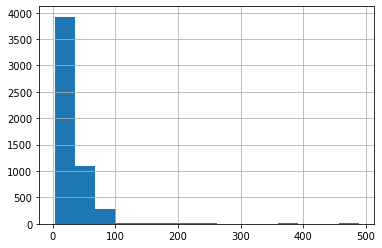

In [32]:
%matplotlib inline
main_dataset['FAERS_drug_match'].apply(len).hist(bins=15)

In [26]:
main_dataset.iloc[5132]['FAERS_drug_match']

"WOMEN'S MULTI (ASCORBIC ACID, BETACAROTENE, BIOTIN, CALCIUM AMINO ACID CHELATE, CALCIUM PANTOTHENATE, CHROMIUM AMINO ACID CHELATE, COPPER AMINO ACID CHELATE, CYANOCOBALAMIN, EQUISETUM ARVENSE STEM, FERROUS FUMARATE, FOLIC ACID, LAMINARIA DIGITATA POWDER, MAGNESIUM OXIDE, MANGANESE AMINO ACID CHELATE, NICOTINAMIDE, OENOTHERA BIENNIS OIL, POTASSIUM AMINO ACID CHELATE, PYRIDOXINE HYDROCHLORIDE, RIBOFLAVIN, SELENIUM AMINO ACID CHELATE, THIAMINE MONONITRATE, ZINC AMINO ACID CHELATE) TABLET"

In [ ]:
main_dataset.iloc[5132]['FAERS_drug_match']

In [133]:
dfneg2['FAERS_drug_match'].apply(len).describe()

count    16879.000000
mean        29.855738
std         31.324787
min          3.000000
25%         15.000000
50%         22.000000
75%         37.000000
max        489.000000
Name: FAERS_drug_match, dtype: float64

In [ ]:
dfneg2['lookup_value'].apply(len).describe()

In [134]:
dUnique_df['dUnique_label'].apply(len).describe()

count    125.000000
mean      13.136000
std        4.590214
min        4.000000
25%        9.000000
50%       13.000000
75%       17.000000
max       24.000000
Name: dUnique_label, dtype: float64

In [132]:
dUnique_df['dUnique_seq'].apply(len).describe()

count    125.000000
mean      13.136000
std        4.590214
min        4.000000
25%        9.000000
50%       13.000000
75%       17.000000
max       24.000000
Name: dUnique_seq, dtype: float64

In [ ]:
dfneg2['FAERS_drug_match'].apply(len).idxmax()

In [138]:
dfneg2.iloc[8183]['FAERS_drug_match']

"WOMEN'S MULTI (ASCORBIC ACID, BETACAROTENE, BIOTIN, CALCIUM AMINO ACID CHELATE, CALCIUM PANTOTHENATE, CHROMIUM AMINO ACID CHELATE, COPPER AMINO ACID CHELATE, CYANOCOBALAMIN, EQUISETUM ARVENSE STEM, FERROUS FUMARATE, FOLIC ACID, LAMINARIA DIGITATA POWDER, MAGNESIUM OXIDE, MANGANESE AMINO ACID CHELATE, NICOTINAMIDE, OENOTHERA BIENNIS OIL, POTASSIUM AMINO ACID CHELATE, PYRIDOXINE HYDROCHLORIDE, RIBOFLAVIN, SELENIUM AMINO ACID CHELATE, THIAMINE MONONITRATE, ZINC AMINO ACID CHELATE) TABLET"